# 01 INTRO: Árboles de Decisión sin Overfitting
Explicación de cómo construír árboles de decisión.


## 0101 Qué es un árbol de decisión?
Un tipo de algoritmo de aprendizaje supervisado que se basa en realizar particiones a partir de distintos niveles de las variables disponibles.

## 0102 Import
Importamos todas las librerías necesarias para este análisis: pandas, numpy, seaborn, matplotlib.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

# Trade-off BIAS vs Variance

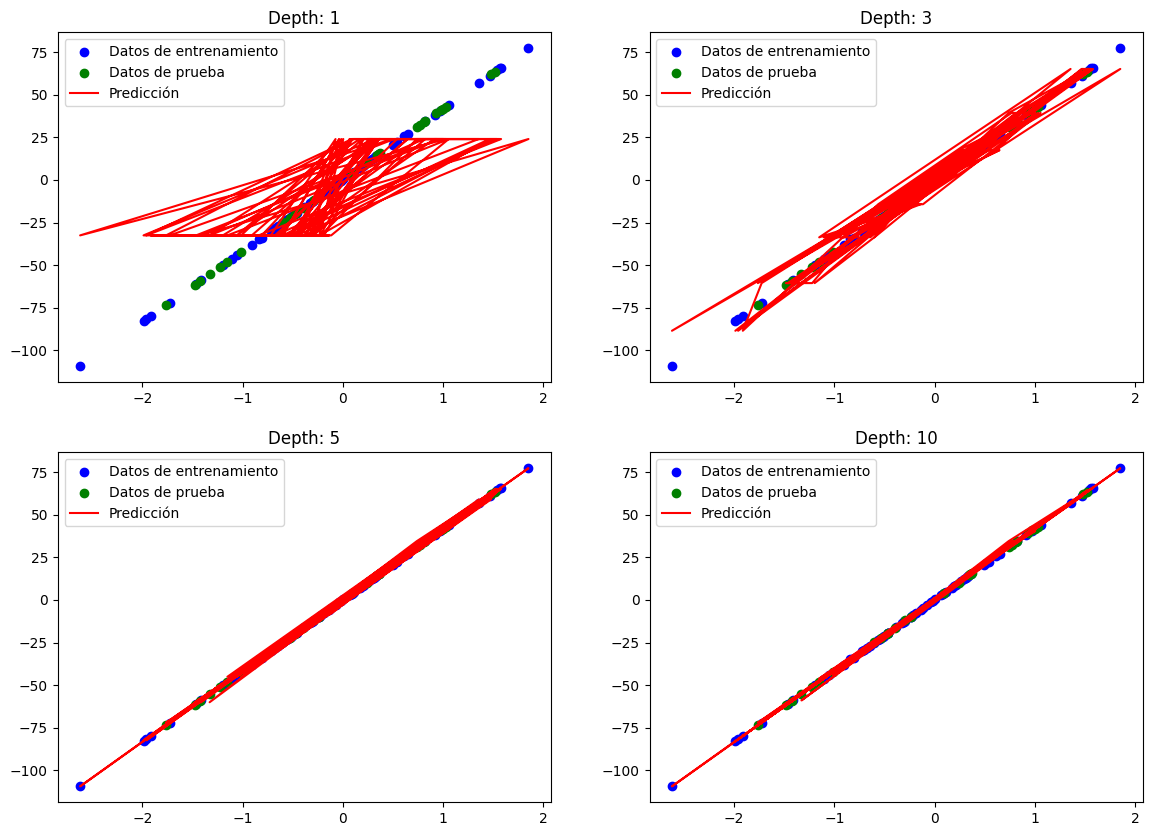

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression

# Generar un conjunto de datos de regresión
X, y = make_regression(n_samples=100, n_features=1, noise=0.1, random_state=42)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear y entrenar múltiples modelos
depths = [1, 3, 5, 10]
plt.figure(figsize=(14, 10))
for i, depth in enumerate(depths, 1):
    # Crear el modelo con una profundidad específica
    regressor = DecisionTreeRegressor(max_depth=depth, random_state=42)
    regressor.fit(X_train, y_train)

    # Realizar predicciones
    y_pred_train = regressor.predict(X_train)
    y_pred_test = regressor.predict(X_test)

    # Graficar resultados
    plt.subplot(2, 2, i)
    plt.scatter(X_train, y_train, color='blue', label='Datos de entrenamiento')
    plt.scatter(X_test, y_test, color='green', label='Datos de prueba')
    plt.plot(X, regressor.predict(X), color='red', label='Predicción')
    plt.title(f'Depth: {depth}')
    plt.legend()

plt.show()


## 0103 Carga el dataset de coches de segunda mano
Para probar a hacer árboles de decisión sin overfitting utilizaremos un dataset sobre el **precio** de distintos **coches de segunda mano** que se encuentra en Kaggle ([aquí](https://www.kaggle.com/harturo123/online-adds-of-used-cars)).

Podéis encontrar el archivo listo para importar en github: https://raw.githubusercontent.com/abelmmg/TheValley_AI/main/coches_usados_esp.csv.

Importa este dataset en un dataframe llamado **df**.

In [ ]:
# Url archivo raw
url = "https://raw.githubusercontent.com/abelmmg/TheValley_AI/main/coches_usados_esp.csv"
# Importa csv
df = pd.read_csv(url, sep=";")

# Visualización primeras filas
df.head()

,ID,make,model,version,months_old,power,sale_type,num_owners,gear_type,fuel_type,kms,price
0,97860,Porsche,911,Carrera 4 S Coup�,240.0,210.0,classic,3.0,manual,gasoline,202000.0,999999
1,27821,Ford,Mustang,Gt500 Cabrio Vendido,54.0,487.0,used,1.0,manual,gasoline,30000.0,685000
2,97801,Porsche,911,3.3 Turbo Targa (Precio A Consultar),358.0,220.0,used,NaN,manual,gasoline,56300.0,555555
3,98251,Porsche,911,R Unidad 343 De 991-Iva Deducible,14.0,368.0,used,1.0,manual,gasoline,2800.0,470000
4,98250,Porsche,911,Gt2 Rs,3.0,515.0,used,NaN,NaN,gasoline,10.0,450000


# 02 EDA
Realizaremos un pequeño análisis exploratorio visual para familiarizarnos con el dataset.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93991 entries, 0 to 93990
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          93991 non-null  int64  
 1   make        93991 non-null  object 
 2   model       93991 non-null  object 
 3   version     93991 non-null  object 
 4   months_old  93717 non-null  float64
 5   power       93504 non-null  float64
 6   sale_type   93979 non-null  object 
 7   num_owners  22660 non-null  float64
 8   gear_type   92710 non-null  object 
 9   fuel_type   93926 non-null  object 
 10  kms         93127 non-null  float64
 11  price       93991 non-null  int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 8.6+ MB


In [ ]:
df.isna().sum()

ID                0
make              0
model             0
version           0
months_old      274
power           487
sale_type        12
num_owners    71331
gear_type      1281
fuel_type        65
kms             864
price             0
dtype: int64

In [ ]:
df.describe()

,ID,months_old,power,num_owners,kms,price
count,93991.00000,93717.000000,93504.000000,22660.000000,93127.000000,93991.000000
mean,55100.87935,63.094775,99.729477,1.055119,82702.565250,16587.291379
std,33119.32602,56.837686,42.698809,0.277124,75186.697789,15563.712383
min,25.00000,1.000000,0.000000,1.000000,0.000000,200.000000
25%,25452.50000,16.000000,77.000000,1.000000,18300.000000,8500.000000
50%,53896.00000,46.000000,88.000000,1.000000,66000.000000,13490.000000
75%,83573.50000,96.000000,110.000000,1.000000,129000.000000,19999.000000
max,113143.00000,374.000000,809.000000,11.000000,497000.000000,999999.000000


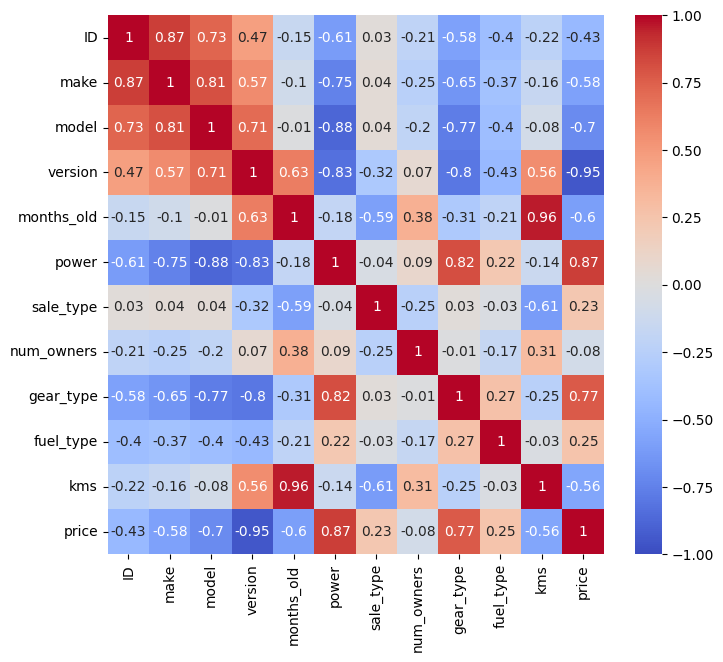

In [ ]:
# Visualización coeficientes Pearson

# Convertir las columnas categóricas a numéricas si es apropiado
# Esto puede ser útil si tienes columnas categóricas que deseas incluir
df_converted = df.copy()
for col in df.columns:
    if df[col].dtype == 'object':
        df_converted[col] = pd.factorize(df[col])[0]

# Ahora calcula la matriz de correlación
corr_matrix = df_converted.corr()

# Solo coger colunmas numericas.
#numeric_df = df.select_dtypes(include=[np.number])
#corr_matrix = numeric_df.corr()

plt.figure(figsize=(8, 7))
sns.heatmap(np.round(corr_matrix.corr(), 2), vmin=-1, vmax=1, annot=True, cmap="coolwarm")
plt.show()

# QUESTION
# ¿Por que no ha fallado si hay datos tipo texto en el dataset?

# 03 EJEMPLO Sin OverFitting
Vamos a ver paso a paso cómo realizar un modelo que prediga el precio sin caer en overfitting.

## 0301 Preparamos los datos
El dataframe tiene algunos nulos, así como variables categóricas y presencia de ciertas variables que probablemente no queramos usar.

### 030101 Variables Útiles
De entre las variables disponibles, veamos cuáles queremos utilizar como predictoras para el estudio.

In [ ]:
df.head()

,ID,make,model,version,months_old,power,sale_type,num_owners,gear_type,fuel_type,kms,price
0,97860,Porsche,911,Carrera 4 S Coup�,240.0,210.0,classic,3.0,manual,gasoline,202000.0,999999
1,27821,Ford,Mustang,Gt500 Cabrio Vendido,54.0,487.0,used,1.0,manual,gasoline,30000.0,685000
2,97801,Porsche,911,3.3 Turbo Targa (Precio A Consultar),358.0,220.0,used,NaN,manual,gasoline,56300.0,555555
3,98251,Porsche,911,R Unidad 343 De 991-Iva Deducible,14.0,368.0,used,1.0,manual,gasoline,2800.0,470000
4,98250,Porsche,911,Gt2 Rs,3.0,515.0,used,NaN,NaN,gasoline,10.0,450000


In [ ]:
df.columns

Index(['ID', 'make', 'model', 'version', 'months_old', 'power', 'sale_type',
       'num_owners', 'gear_type', 'fuel_type', 'kms', 'price'],
      dtype='object')

In [ ]:
# se quita ID y version
cols = [
    "make",
    "model",
    "months_old",
    "power",
    "sale_type",
    "num_owners",
    "gear_type",
    "fuel_type",
    "kms",
    "price",
]

### 030102 Dumificación de variables categóricas

In [ ]:
df_i = pd.get_dummies(
    df[cols],
    prefix_sep="_",
    drop_first=True,
    columns=["make", "model", "sale_type", "gear_type", "fuel_type"],
)

display(len(df_i))
df_i.head()

93991

,months_old,power,num_owners,kms,price,make_Audi,make_Bentley,make_Bmw,make_Chevrolet,make_Chrysler,...,sale_type_new,sale_type_used,gear_type_manual,gear_type_semi-automatic,fuel_type_LPG,fuel_type_diesel,fuel_type_electric,fuel_type_etanol,fuel_type_gasoline,fuel_type_hybrid
0,240.0,210.0,3.0,202000.0,999999,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
1,54.0,487.0,1.0,30000.0,685000,False,False,False,False,False,...,False,True,True,False,False,False,False,False,True,False
2,358.0,220.0,NaN,56300.0,555555,False,False,False,False,False,...,False,True,True,False,False,False,False,False,True,False
3,14.0,368.0,1.0,2800.0,470000,False,False,False,False,False,...,False,True,True,False,False,False,False,False,True,False
4,3.0,515.0,NaN,10.0,450000,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False


In [ ]:
print(df_i.columns)

# QUESTION
# ¿ Cómo ver todas las columnas creadas?

Index(['months_old', 'power', 'num_owners', 'kms', 'price', 'make_Audi',
       'make_Bentley', 'make_Bmw', 'make_Chevrolet', 'make_Chrysler',
       ...
       'sale_type_new', 'sale_type_used', 'gear_type_manual',
       'gear_type_semi-automatic', 'fuel_type_LPG', 'fuel_type_diesel',
       'fuel_type_electric', 'fuel_type_etanol', 'fuel_type_gasoline',
       'fuel_type_hybrid'],
      dtype='object', length=299)


In [ ]:
print(list(df_i.columns))

['months_old', 'power', 'num_owners', 'kms', 'price', 'make_Audi', 'make_Bentley', 'make_Bmw', 'make_Chevrolet', 'make_Chrysler', 'make_Citroen', 'make_Dacia', 'make_Ds', 'make_Fiat', 'make_Ford', 'make_Honda', 'make_Hyundai', 'make_Iveco', 'make_Jaguar', 'make_Jeep', 'make_Kia', 'make_Land', 'make_Mazda', 'make_Mercedes-Benz', 'make_Mini', 'make_Mitsubishi', 'make_Nissan', 'make_Opel', 'make_Peugeot', 'make_Porsche', 'make_Renault', 'make_Saab', 'make_Seat', 'make_Skoda', 'make_Smart', 'make_Ssangyong', 'make_Suzuki', 'make_Toyota', 'make_Volkswagen', 'make_Volvo', 'model_118', 'model_120', 'model_2008', 'model_206', 'model_207', 'model_208', 'model_216', 'model_218', 'model_220', 'model_3', 'model_3008', 'model_307', 'model_308', 'model_316', 'model_318', 'model_320', 'model_325', 'model_330', 'model_407', 'model_420', 'model_500', 'model_5008', 'model_500C', 'model_500L', 'model_500X', 'model_508', 'model_520', 'model_525', 'model_530', 'model_6', 'model_640', 'model_730', 'model_9-

### 030103 Limpieza de nulos
Con la dumificación hemos eliminado los nulos en las columnas categóricas sin deshacernos de las filas. Queda algún nulo en las variables numéricas?


In [ ]:
# Solo mostrar la columnas con null.
# df_i[["months_old", "power", "num_owners", "kms", "price"]].isna().sum()
null_counts = df_i.isnull().sum()
columns_with_nulls = null_counts[null_counts > 0]
print(columns_with_nulls)

months_old      274
power           487
num_owners    71331
kms             864
dtype: int64


In [ ]:
# Hay muchos nulos en num_owners
# Quizás esto tiene que ver con origenes del coche desconocidos?
# Vamos a limpiar la variable en 1, 2, 3+, nulo y la utilizamos como categórica
filtro_muchos_owners = df_i["num_owners"] >= 3
df_i.loc[filtro_muchos_owners, "num_owners"] = "3+"
df_i = pd.get_dummies(
    df_i, prefix_sep="_", dummy_na=True, drop_first=True, columns=["num_owners"]
)
df_i.head()

,months_old,power,kms,price,make_Audi,make_Bentley,make_Bmw,make_Chevrolet,make_Chrysler,make_Citroen,...,gear_type_semi-automatic,fuel_type_LPG,fuel_type_diesel,fuel_type_electric,fuel_type_etanol,fuel_type_gasoline,fuel_type_hybrid,num_owners_2.0,num_owners_3+,num_owners_nan
0,240.0,210.0,202000.0,999999,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
1,54.0,487.0,30000.0,685000,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,358.0,220.0,56300.0,555555,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
3,14.0,368.0,2800.0,470000,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,3.0,515.0,10.0,450000,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True


In [ ]:
df_i[["months_old", "power", "kms", "price"]].isna().sum()

months_old    274
power         487
kms           864
price           0
dtype: int64

In [ ]:
# Para el resto de características se asgina el valor de su mediana.
for col in ["months_old", "power", "kms"]:
    df_i[col] = df_i[col].fillna(df_i[col].median())

In [ ]:
# Verificar que no quedan columnas con null.
# Solo mostrar la columnas con null.
null_counts = df_i.isnull().sum()
columns_with_nulls = null_counts[null_counts > 0]
print(len(columns_with_nulls))
print(columns_with_nulls)

0
Series([], dtype: int64)


##0302 Train - test split
Separamos el set de datos en dos utilizando [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).


In [ ]:
X = df_i.drop("price", axis=1)
y = df_i["price"]

len(X), len(y)

(93991, 93991)

In [ ]:
X.shape, y.shape

((93991, 300), (93991,))

In [ ]:
# train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 0303 Entrenamos el árbol de decisión
Sobre el set de entrenamiento, comprobamos el modelo sobre el set de test.
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor

In [ ]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(max_depth=10)
# Entreno el árbol con el set de entrenamiento
modelo = modelo.fit(X=X_train, y=y_train)
# Uso el árbol para predecir sobre el dataset de entrenamiento
y_pred_train = modelo.predict(X_train)
# Uso el árbol para predecir sobre el dataset de test
y_pred_test = modelo.predict(X_test)
# Cómo de buena es la predicción?
print(
    "RMSE en set de entrenamiento :",
    mean_squared_error(y_train, y_pred_train, squared=False),
)
print("RMSE en set de test :", mean_squared_error(y_test, y_pred_test, squared=False))

RMSE en set de entrenamiento : 4212.870964705138
RMSE en set de test : 5610.3437090846655


In [ ]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(max_depth=5)
# Entreno el árbol con el set de entrenamiento
modelo = modelo.fit(X=X_train, y=y_train)
# Uso el árbol para predecir sobre el dataset de entrenamiento
y_pred_train = modelo.predict(X_train)
# Uso el árbol para predecir sobre el dataset de test
y_pred_test = modelo.predict(X_test)
# Cómo de buena es la predicción?
print(
    "RMSE en set de entrenamiento :",
    mean_squared_error(y_train, y_pred_train, squared=False),
)
print("RMSE en set de test :", mean_squared_error(y_test, y_pred_test, squared=False))

RMSE en set de entrenamiento : 7140.0614444012435
RMSE en set de test : 7299.206539578955


In [ ]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(max_depth=50)
# Entreno el árbol con el set de entrenamiento
modelo = modelo.fit(X=X_train, y=y_train)
# Uso el árbol para predecir sobre el dataset de entrenamiento
y_pred_train = modelo.predict(X_train)
# Uso el árbol para predecir sobre el dataset de test
y_pred_test = modelo.predict(X_test)
# Cómo de buena es la predicción?
print(
    "RMSE en set de entrenamiento :",
    mean_squared_error(y_train, y_pred_train, squared=False),
)
print("RMSE en set de test :", mean_squared_error(y_test, y_pred_test, squared=False))

RMSE en set de entrenamiento : 375.8288396572212
RMSE en set de test : 5562.951258335865


In [ ]:
def entrenar_modelo_y_predecir(modelo, max_depth):
    # Entreno el árbol con el set de entrenamiento
    modelo = modelo.fit(X=X_train, y=y_train)
    # Uso el árbol para predecir sobre el dataset de entrenamiento
    y_pred_train = modelo.predict(X_train)
    # Uso el árbol para predecir sobre el dataset de test
    y_pred_test = modelo.predict(X_test)
    # Cómo de buena es la predicción?
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    #print("max_depth=", max_depth, " RMSE en set de entrenamiento :", rmse_train, )
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
    #print("max_depth=", max_depth,  " RMSE en set de test          :", rmse_test  )

    data = [max_depth, rmse_train, rmse_test]
    cols=['max_depth', 'rmse_train', 'rmse_test']
    serie = pd.Series(data, index=cols)
    return serie

In [ ]:
def run_modelo_y_predecir(max_depth):
    modelo = tree.DecisionTreeRegressor(max_depth=max_depth)
    return entrenar_modelo_y_predecir(modelo, max_depth)


In [ ]:
print(run_modelo_y_predecir(max_depth=5))
print(run_modelo_y_predecir(max_depth=10))
print(run_modelo_y_predecir(max_depth=25))
print(run_modelo_y_predecir(max_depth=30))
print(run_modelo_y_predecir(max_depth=50))

max_depth        5.000000
rmse_train    7140.061444
rmse_test     7299.206540
dtype: float64
max_depth       10.000000
rmse_train    4212.870965
rmse_test     5600.488923
dtype: float64
max_depth       25.000000
rmse_train    1126.765649
rmse_test     5618.838604
dtype: float64
max_depth       30.000000
rmse_train     816.955784
rmse_test     5704.316678
dtype: float64
max_depth       50.000000
rmse_train     375.828840
rmse_test     5746.298189
dtype: float64


In [ ]:
def entrenar_lista_profundidades(lista):
  cols = ['max_depth', 'rmse_train', 'rmse_test']
  df = pd.DataFrame(columns=cols)

  for valor in lista:
    serie = run_modelo_y_predecir(max_depth=valor)
    #df = df.append(serie, ignore_index=True)
    # Agrega la nueva serie como última fila del DataFrame
    df.loc[len(df)] = serie

  return df

In [ ]:
lista = [5, 6, 7, 8, 9, 10, 15, 25, 30, 50]
df_rmse = entrenar_lista_profundidades(lista)
df_rmse

,max_depth,rmse_train,rmse_test
0,5.0,7140.061444,7299.206540
1,6.0,6438.043723,6657.606431
2,7.0,5865.840809,6249.538207
3,8.0,5200.350653,5955.495558
4,9.0,4665.124178,5790.115823
5,10.0,4212.870965,5583.750546
6,15.0,2629.306655,5750.983457
7,25.0,1126.273914,5686.688178
8,30.0,816.791218,5583.384374
9,50.0,375.828840,5725.288568


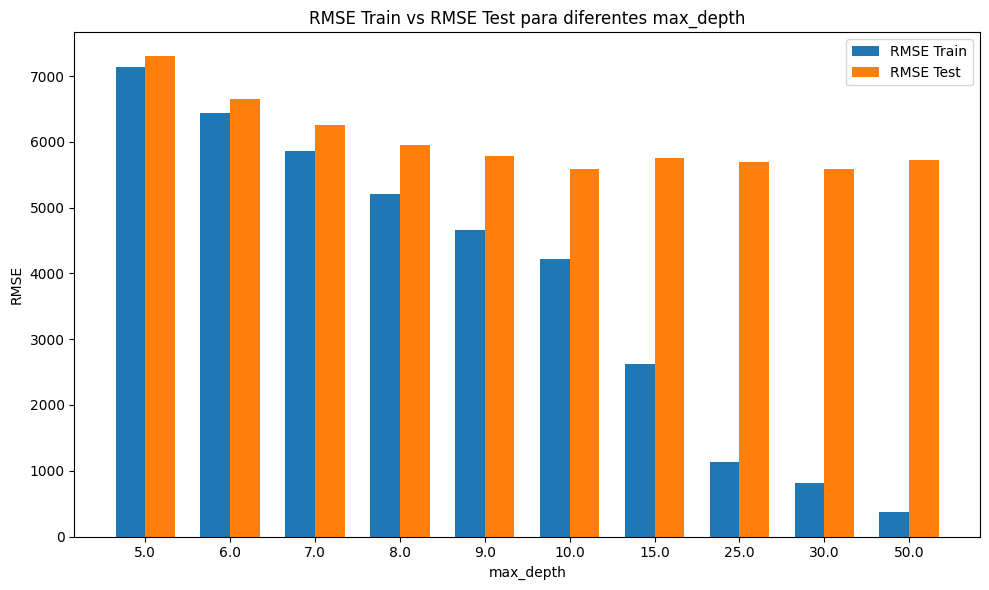

In [ ]:
# Extraer los datos relevantes para el gráfico
max_depth = df_rmse['max_depth']
rmse_train = df_rmse['rmse_train']
rmse_test = df_rmse['rmse_test']

# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Configurar las posiciones de las barras
bar_width = 0.35
index = range(len(max_depth))

# Grafico de barras
plt.bar(index, rmse_train, bar_width, label='RMSE Train')
plt.bar([i + bar_width for i in index], rmse_test, bar_width, label='RMSE Test')

# Configurar etiquetas y título
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.title('RMSE Train vs RMSE Test para diferentes max_depth')
plt.xticks([i + bar_width / 2 for i in index], max_depth)
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

## 0304 Probamos medidas contra el overfitting

### 030401 min_samples_split
Tamaño muestral mínimo para permitir una partición.

In [ ]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(max_depth=10, min_samples_split=20)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir(modelo, max_depth=10)

max_depth       10.000000
rmse_train    5767.079011
rmse_test     5805.837721
dtype: float64

In [ ]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(max_depth=15, min_samples_split=20)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir(modelo, max_depth=15)

max_depth       15.000000
rmse_train    5157.930974
rmse_test     5543.815112
dtype: float64

In [ ]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(max_depth=15, min_samples_split=25)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir(modelo, max_depth=15)

max_depth       15.000000
rmse_train    5233.351079
rmse_test     5518.619601
dtype: float64

### 030402 min_samples_leaf
Tamaño muestral mínimo en una hoja.

In [ ]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(
    max_depth=15, min_samples_split=25, min_samples_leaf=10
)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir(modelo, max_depth=15)

max_depth       15.000000
rmse_train    6399.307655
rmse_test     5866.841568
dtype: float64

In [ ]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(
    max_depth=20, min_samples_split=20, min_samples_leaf=2
)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir(modelo, max_depth=20)

max_depth       20.000000
rmse_train    5467.303845
rmse_test     5774.377685
dtype: float64

### 030402 min_impurity_decrease
Mínimo descenso de impuridad.

Cantidad mínima de disminución de la impureza necesaria para realizar una división en un nodo. Este parámetro ayuda a prevenir el sobreajuste al asegurar que solo las divisiones que aportan una mejora significativa en la pureza del nodo sean consideradas.

In [ ]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(
    max_depth=15, min_samples_split=25, min_impurity_decrease=0.25
)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir(modelo, max_depth=15)

max_depth       15.000000
rmse_train    5233.351079
rmse_test     5520.247243
dtype: float64

# EJERCICIO TITANIC

Vamos a resolver este problema teniendo en cuenta todo lo que sabemos ya. El objetivo es crear una árbol de decisión que prediga si un pasajero falleció o no (pasajeros cuyos datos no conocemos todavía).

Toma las medidas oportunas para que tu modelo sea lo más preciso posible sin caer en overfitting.

Campos:
* Survived: Variable factor, 1 (el pasajero sobrevivió) 0 (el pasajero no sobrevivió).
* Pclass: En que clase viajaba el pasajero (1 = primera, 2 = segunda, 3 = * tercera).
* Sex: Sexo del pasajero.
* Age: Edad del pasajero.
* SibSp: Cantidad de hermanos o cónyuges a bordo del Titanic.
* Parch: Cantidad de padres o hijos a bordo del Titanic.
* Fare: Tarifa del pasajero.
* Embarked: Puerto donde embarco el pasajero (C = Cherbourg, Q = Queenstown, S = Southampton

## Importa el dataset
Puedes encontrarlo en github. Este es el link al archivo raw:
https://raw.githubusercontent.com/abelmmg/TheValley_AI/main/titanic_limpio.csv


Importa los datos en un dataframe llamado dataframe **df_titanic**.

In [ ]:
# TODO ...

##  Prepara los datos
Quédate con las variables interesantes, dumifica las categóricas y limpia los nulos.

In [ ]:
# TODO ...

## Train - test split
Utiliza una partición del 30% para tu set de pruebas.

In [ ]:
# TODO ...

## Entrena varios árboles
Entrena varios árboles de decisión controlando los distintos parámetros para buscar el punto óptimo entre bias y varianza.

In [ ]:
# TODO ...